In [2]:
pip install numpy matplotlib tqdm

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import random

# for reproducibility
np.random.seed(42)
random.seed(42)

In [6]:
class Gridworld3D:
    def __init__(self, size=(6, 6, 6), slip_prob=0.2):
        self.H, self.W, self.D = size
        self.size = size
        self.slip_prob = slip_prob

        self.goal_pos = (5, 5, 5)
        self.pit_pos = (2, 2, 2)
        
        self.obstacles = self._generate_obstacles()

        self.actions = {
            0: (1, 0, 0),   # East
            1: (-1, 0, 0),  # West
            2: (0, 1, 0),   # North
            3: (0, -1, 0),  # South
            4: (0, 0, 1),   # Up
            5: (0, 0, -1)   # Down
        }
        self.num_actions = len(self.actions)

        self.start_pos = self._get_random_start()
        self.agent_pos = self.start_pos

    def _generate_obstacles(self):
        
        fixed_obstacles = [
            (1, 1, 1), (1, 2, 1), (2, 1, 1), (1, 1, 2),
            (3, 3, 3), (3, 4, 3), (4, 3, 3), (3, 3, 4),
            (5, 1, 4), (1, 5, 4), (4, 1, 5), (1, 4, 5)
        ]
        
        if self.goal_pos in fixed_obstacles: fixed_obstacles.remove(self.goal_pos)
        if self.pit_pos in fixed_obstacles: fixed_obstacles.remove(self.pit_pos)
        return fixed_obstacles

    def _get_random_start(self):
        while True:
            start = (
                random.randint(0, self.W - 1),
                random.randint(0, self.D - 1),
                random.randint(0, self.H - 1)
            )
            if start not in self.obstacles and start != self.goal_pos and start != self.pit_pos:
                return start

    def reset(self):
        self.agent_pos = self._get_random_start()
        return self.agent_pos

    def is_terminal(self, pos):
        return pos == self.goal_pos or pos == self.pit_pos

    def _get_perpendicular_actions(self, action):
        intended_move = self.actions[action]
        perp_actions = []
        for a, move in self.actions.items():
          
            if np.dot(intended_move, move) == 0:
                perp_actions.append(a)
        return perp_actions

    def step(self, action):
        if self.is_terminal(self.agent_pos):
            return self.agent_pos, 0, True

        
        if random.random() < self.slip_prob:
            action = random.choice(self._get_perpendicular_actions(action))
        
        move = self.actions[action]
        next_pos = (
            self.agent_pos[0] + move[0],
            self.agent_pos[1] + move[1],
            self.agent_pos[2] + move[2]
        )

        if not (0 <= next_pos[0] < self.W and \
                0 <= next_pos[1] < self.D and \
                0 <= next_pos[2] < self.H and \
                next_pos not in self.obstacles):
            next_pos = self.agent_pos 

        self.agent_pos = next_pos

        done = self.is_terminal(self.agent_pos)
        if self.agent_pos == self.goal_pos:
            reward = 50
        elif self.agent_pos == self.pit_pos:
            reward = -50
        else:
            reward = -1 

        return self.agent_pos, reward, done

100%|██████████| 15000/15000 [00:18<00:00, 804.40it/s] 


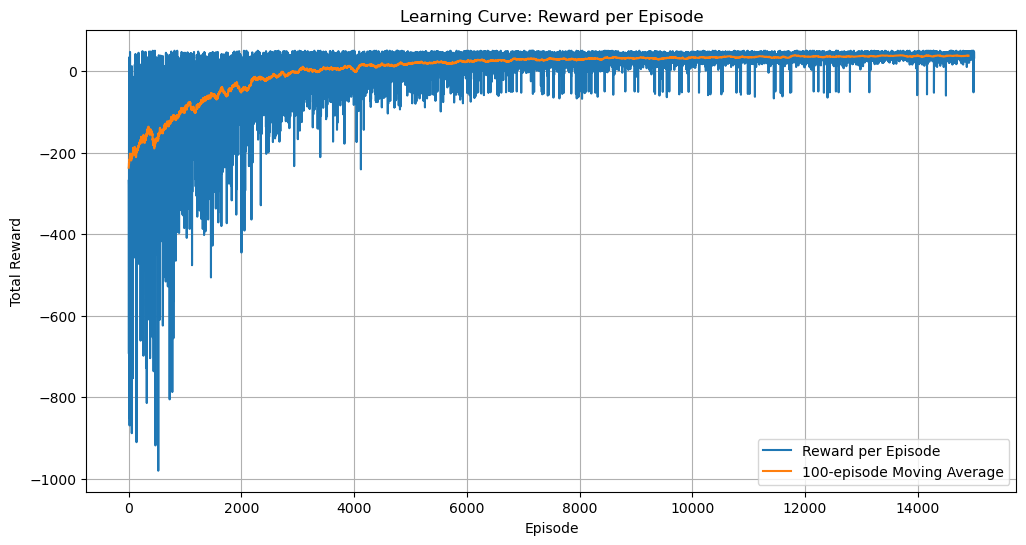

In [7]:
class QLearningAgent:
    def __init__(self, env, alpha=0.1, gamma=0.95, epsilon=1.0, epsilon_decay=0.9999, epsilon_min=0.01):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        self.q_table = np.zeros(env.size + (env.num_actions,))

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.choice(list(self.env.actions.keys())) 
        else:
            return np.argmax(self.q_table[state])

    def update_q_table(self, state, action, reward, next_state):
        old_value = self.q_table[state][action]
        next_max = np.max(self.q_table[next_state])
        
        new_value = old_value + self.alpha * (reward + self.gamma * next_max - old_value)
        self.q_table[state][action] = new_value

    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

def train(agent, episodes=15000):
    rewards_history = []
    
    for episode in tqdm(range(episodes)):
        state = agent.env.reset()
        total_reward = 0
        done = False
        
        while not done:
            action = agent.choose_action(state)
            next_state, reward, done = agent.env.step(action)
            agent.update_q_table(state, action, reward, next_state)
            state = next_state
            total_reward += reward
        
        rewards_history.append(total_reward)
        agent.decay_epsilon()
        
    return rewards_history

env = Gridworld3D()
agent = QLearningAgent(env)


rewards = train(agent)


plt.figure(figsize=(12, 6))
plt.plot(rewards)
plt.title('Learning Curve: Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
moving_avg = np.convolve(rewards, np.ones(100)/100, mode='valid')
plt.plot(moving_avg)
plt.legend(['Reward per Episode', '100-episode Moving Average'])
plt.grid(True)
plt.show()

In [8]:
def evaluate_policy(agent, env, episodes=100):
    total_rewards = 0
    for _ in range(episodes):
        state = env.reset()
        done = False
        episode_reward = 0
        while not done:
            action = np.argmax(agent.q_table[state])
            state, reward, done = env.step(action)
            episode_reward += reward
        total_rewards += episode_reward
    return total_rewards / episodes

def evaluate_random_policy(env, episodes=100):
    total_rewards = 0
    for _ in range(episodes):
        state = env.reset()
        done = False
        episode_reward = 0
        while not done:
            action = random.choice(list(env.actions.keys())) # Random action
            state, reward, done = env.step(action)
            episode_reward += reward
        total_rewards += episode_reward
    return total_rewards / episodes

avg_return_learned = evaluate_policy(agent, env)
print(f"Average return of the learned policy over 100 episodes: {avg_return_learned:.2f}")

avg_return_random = evaluate_random_policy(env)
print(f"Average return of the random policy over 100 episodes: {avg_return_random:.2f}")

Average return of the learned policy over 100 episodes: 40.80
Average return of the random policy over 100 episodes: -204.20



--- Visualizing Policy Slices ---


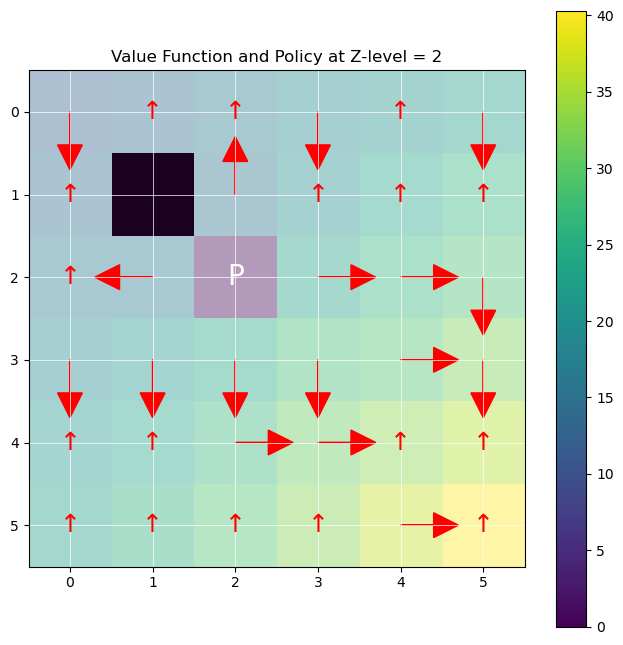

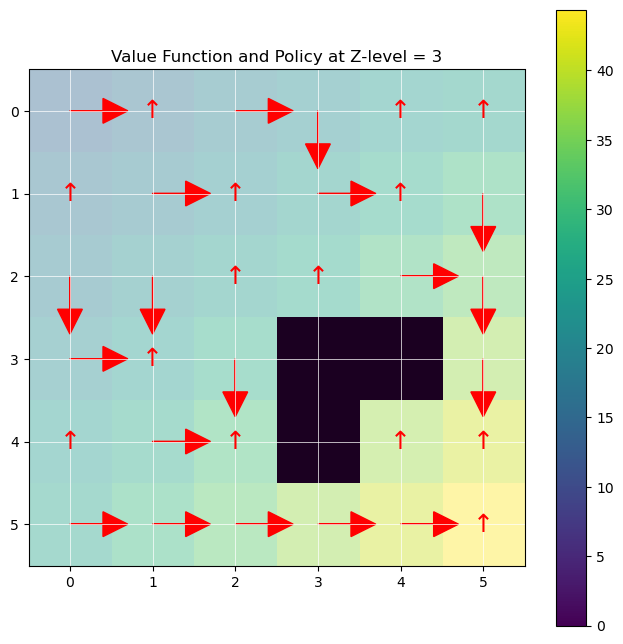

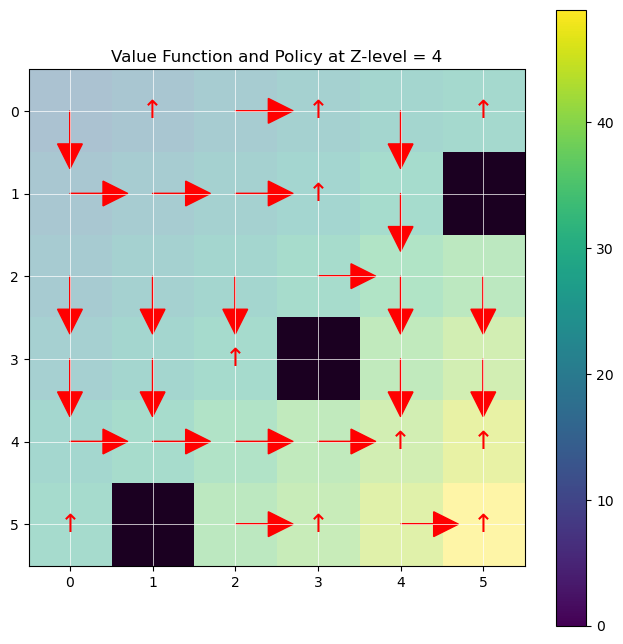

In [9]:
def visualize_policy_slice(q_table, env, z_level):
    H, W, D = env.size
    value_slice = np.max(q_table[:, :, z_level, :], axis=2)
    policy_slice = np.argmax(q_table[:, :, z_level, :], axis=2)
    
    obstacle_map = np.zeros((W, H))
    for obs in env.obstacles:
        if obs[2] == z_level:
            obstacle_map[obs[0], obs[1]] = 1

    fig, ax = plt.subplots(figsize=(8, 8))
    
    c = ax.imshow(value_slice.T, cmap='viridis', interpolation='none')
    fig.colorbar(c, ax=ax)
    
    ax.imshow(obstacle_map.T, cmap='Greys', interpolation='none', alpha=0.6)

    for x in range(W):
        for y in range(H):
            if (x, y, z_level) in env.obstacles:
                continue
            if (x, y, z_level) == env.goal_pos:
                ax.text(x, y, 'G', ha='center', va='center', color='white', fontsize=20)
                continue
            if (x, y, z_level) == env.pit_pos:
                ax.text(x, y, 'P', ha='center', va='center', color='white', fontsize=20)
                continue
            
            action = policy_slice[x, y]
            dx, dy, dz = env.actions[action]

            if dz == 0:
                ax.arrow(x, y, dx*0.4, dy*0.4, head_width=0.3, head_length=0.3, fc='red', ec='red')

            elif dz > 0:
                 ax.text(x, y, '↑', ha='center', va='center', color='red', fontsize=18)
            else: # dz < 0
                 ax.text(x, y, '↓', ha='center', va='center', color='red', fontsize=18)


    ax.set_title(f'Value Function and Policy at Z-level = {z_level}')
    ax.set_xticks(np.arange(W))
    ax.set_yticks(np.arange(H))
    ax.set_xticklabels(np.arange(W))
    ax.set_yticklabels(np.arange(H))
    plt.grid(True, which='both', color='white', linewidth=0.5, linestyle='-')
    plt.show()

print("\n--- Visualizing Policy Slices ---")
visualize_policy_slice(agent.q_table, env, z_level=2)
visualize_policy_slice(agent.q_table, env, z_level=3)
visualize_policy_slice(agent.q_table, env, z_level=4)